In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os

import tensorflow as tf
from tensorflow import keras
from keras import backend
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, History
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (concatenate, Input, Dense, Dropout, BatchNormalization, 
                                     LSTM, Flatten, Conv1D, MaxPool1D, UpSampling2D,
                                     Conv2D, MaxPool2D)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import IPython.display as ipd
from IPython.display import Audio

#from google.colab import files

#%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
music_genres = os.listdir('/content/drive/MyDrive/UAI/Data_CSV/genres_music/')

In [ ]:
music_genres

['country',
 'rock',
 'hiphop',
 'metal',
 'pop',
 'classical',
 'disco',
 'reggae',
 'jazz',
 'blues']

In [ ]:
print(os.listdir('/content/drive/MyDrive/UAI/Data_CSV/genres_music/disco'))

['disco.00001.au', 'disco.00000.au', 'disco.00002.au', 'disco.00009.au', 'disco.00006.au', 'disco.00018.au', 'disco.00003.au', 'disco.00017.au', 'disco.00014.au', 'disco.00005.au', 'disco.00012.au', 'disco.00019.au', 'disco.00013.au', 'disco.00008.au', 'disco.00016.au', 'disco.00011.au', 'disco.00004.au', 'disco.00015.au', 'disco.00010.au', 'disco.00007.au', 'disco.00027.au', 'disco.00029.au', 'disco.00026.au', 'disco.00031.au', 'disco.00022.au', 'disco.00028.au', 'disco.00035.au', 'disco.00030.au', 'disco.00025.au', 'disco.00032.au', 'disco.00034.au', 'disco.00023.au', 'disco.00024.au', 'disco.00020.au', 'disco.00033.au', 'disco.00021.au', 'disco.00046.au', 'disco.00041.au', 'disco.00049.au', 'disco.00050.au', 'disco.00044.au', 'disco.00038.au', 'disco.00045.au', 'disco.00047.au', 'disco.00037.au', 'disco.00048.au', 'disco.00039.au', 'disco.00042.au', 'disco.00043.au', 'disco.00051.au', 'disco.00040.au', 'disco.00036.au', 'disco.00054.au', 'disco.00062.au', 'disco.00059.au', 'disco.00

In [4]:
# Параметризуем music
def get_features(y, sr):
    music_chroma = librosa.feature.chroma_stft(y=y, sr=sr)         # 12 полутонов
    music_mfcc = librosa.feature.mfcc(y=y, sr=sr)                  # 20 спектральных коэффициентов
    
    music_rms = np.mean(librosa.feature.rms(y=y))                            # среднеквадратичная амплитуда
    music_specCent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))  # спектральный центроид
    music_specBw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))  # ширина полосы частот
    music_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))   # спектральный распад частот
    music_zcr = np.mean(librosa.feature.zero_crossing_rate(y))              # частота пересечения нуля
    
    # список всех параметров
    out_all = []
    out_all.append(music_specCent)
    out_all.append(music_rms)
    out_all.append(music_specBw)
    out_all.append(music_rolloff)
    out_all.append(music_zcr)
    for c in music_chroma:
        out_all.append(np.mean(c))
    for f in music_mfcc:
        out_all.append(np.mean(f))

    # возвращаем полученный список
    return out_all

In [5]:
# Создаем обучающую выборку
X_train = [] 
y_train = []

for i in range(len(music_genres)):
    g = music_genres[i]
    for filename in os.listdir(f'/content/drive/MyDrive/UAI/Data_CSV/genres_music/{g}'):
        songname = f'/content/drive/MyDrive/UAI/Data_CSV/genres_music/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=90) # y-массив, sr-частота дисредитации, duration-продолжительность сек.
        # сигнал в параметризованные данные
        out_all = get_features(y, sr)
        # добавляем в X_train
        X_train.append(out_all)
        # добавляем в Y_train в формате OHE
        y_train.append(to_categorical(i, len(music_genres)))

    print(f'Жанр: {g}')


Жанр: country
Жанр: rock
Жанр: hiphop
Жанр: metal
Жанр: pop
Жанр: classical
Жанр: disco
Жанр: reggae
Жанр: jazz
Жанр: blues


In [6]:
len(out_all)

37

In [7]:
# Обучающую выборку в numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

In [8]:
# Backup обучающей выборки
X_train_backup = X_train.copy()
y_train_backup = y_train.copy()

In [9]:
# Контроль номеров классов
y_train_class = np.argmax(y_train, axis=1)
y_train_class

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,

In [10]:
# Размеры обучающей выборки
print(f'{X_train.shape} \n{y_train.shape} \n{y_train_class.shape}')

(1000, 37) 
(1000, 10) 
(1000,)


In [11]:
# Нормализуем данные
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train

array([[ 1.02902719,  1.51692881,  1.13508779, ...,  0.59903528,
         0.15715719,  0.53960046],
       [ 1.06805827,  1.19676394,  1.15114901, ..., -0.06881924,
        -0.82876593,  0.76209654],
       [ 0.83295389,  1.78961488,  1.15009425, ...,  0.91926141,
         0.86259179,  1.35354388],
       ...,
       [ 0.1519242 , -0.0833855 , -0.06835821, ...,  0.16847487,
        -0.42197139,  1.12934   ],
       [-0.82345426,  0.0147929 , -0.51500116, ..., -0.85711143,
         1.26811016, -1.11697953],
       [-2.28023305, -0.99089312, -2.37014982, ..., -0.0852311 ,
         1.1706865 , -0.46904105]])

In [12]:
# Разделяем выборку на train и  test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)

In [13]:
# Размеры выборок
print(f'{X_train.shape} \n{y_train.shape} \n{X_test.shape} \n{y_test.shape}')

(900, 37) 
(900,) 
(100, 37) 
(100,)


Создаем нейронку Var1

In [107]:
indexes = range(0, 37)

model_Dense = Sequential([
                    BatchNormalization(input_shape=(len(indexes),)),
                    Dense(512, activation='relu'), #input_shape=(len(indexes),)),
                    #Dense(32, activation='relu'),
                    #Flatten(),
                    BatchNormalization(),
                    Dropout(0.5),
                    #Dense(4096, activation='relu'),
                    #Flatten(),
                    Dense(384, activation='relu'),
                    #BatchNormalization(),
                    Dropout(0.3),
                    #BatchNormalization(),
                    #Dense(128, activation='relu'),
                    #Dense(128, activation='relu'),
                    Dense(256, activation='relu'),
                    #BatchNormalization(),
                    Dropout(0.2),
                    #Dense(64, activation='relu'),
                    #Dense(64, activation='relu'),
                    #UpSampling2D(size=(2), data_format=None),
                    #Dropout(0.2),
                    #Dropout(0.4),
                    #BatchNormalization(),
                    #Dense(64, activation='relu'),
                    #BatchNormalization(),
                    Dense(128, activation='relu'),
                    #Dropout(0.2),
                    Dense(64, activation='relu'),
                    #Dense(16, activation='relu'),
                    #BatchNormalization(),
                    Flatten(),
                    Dense(10, activation='softmax')
                    ])

In [108]:
model_Dense.compile(optimizer=RMSprop(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])   # Adam

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [109]:
model_Dense.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_22 (Batc (None, 37)                148       
_________________________________________________________________
dense_61 (Dense)             (None, 512)               19456     
_________________________________________________________________
batch_normalization_23 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_38 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 384)               196992    
_________________________________________________________________
dropout_39 (Dropout)         (None, 384)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 256)             

In [110]:
class MyPersonalCallbacs(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()


    def on_epoch_end(self, epoch, logs=None):
        History = self.model.history.history
        if epoch > 0:
            lr = float(backend.get_value(self.model.optimizer.lr))
            print(f'learing_rate= {lr:.5f}')


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_delta=0.0001, min_lr=0.01, mode='auto')

In [111]:
histoty_Dense = model_Dense.fit(X_train[:, indexes], y_train, epochs=500, batch_size=16, verbose=1, callbacks=[MyPersonalCallbacs(), reduce_lr], validation_data=(X_test[:, indexes], y_test))

Epoch 1/500
57/57 [==============================] - 2s 12ms/step - loss: 2.3743 - accuracy: 0.1444 - val_loss: 2.2303 - val_accuracy: 0.3800
Epoch 2/500
57/57 [==============================] - 0s 9ms/step - loss: 2.1571 - accuracy: 0.2489 - val_loss: 2.1281 - val_accuracy: 0.3900
learing_rate= 0.00010
Epoch 3/500
57/57 [==============================] - 0s 9ms/step - loss: 2.0248 - accuracy: 0.2956 - val_loss: 1.9911 - val_accuracy: 0.4200
learing_rate= 0.00010
Epoch 4/500
57/57 [==============================] - 0s 8ms/step - loss: 1.9103 - accuracy: 0.3267 - val_loss: 1.8279 - val_accuracy: 0.4500
learing_rate= 0.00010
Epoch 5/500
57/57 [==============================] - 0s 8ms/step - loss: 1.8498 - accuracy: 0.3500 - val_loss: 1.6840 - val_accuracy: 0.5000
learing_rate= 0.00010
Epoch 6/500
57/57 [==============================] - 0s 9ms/step - loss: 1.7305 - accuracy: 0.3856 - val_loss: 1.5338 - val_accuracy: 0.5100
learing_rate= 0.00010
Epoch 7/500
57/57 [========================

In [112]:
model_Dense.evaluate(X_test, y_test, verbose=1)

4/4 [==============================] - 0s 4ms/step - loss: 1.0677 - accuracy: 0.7800


[1.0676603317260742, 0.7799999713897705]

In [113]:
# максимальная точность  и ошибка на обучающей и проверочной выборе
print(f'Максимальная Точность на обучающей выборке: {max(histoty_Dense.history["accuracy"])} \
\nМинимальная ошибка на обучающей выборе: {min(histoty_Dense.history["loss"])} \
\nМаксимальная Точность на проверочной выборке: {max(histoty_Dense.history["val_accuracy"])} \
\nМинимальная ошибка на проверочной выборе: {min(histoty_Dense.history["val_loss"])}')

Максимальная Точность на обучающей выборке: 0.9433333277702332 
Минимальная ошибка на обучающей выборе: 0.17713095247745514 
Максимальная Точность на проверочной выборке: 0.8199999928474426 
Минимальная ошибка на проверочной выборе: 0.7918177247047424


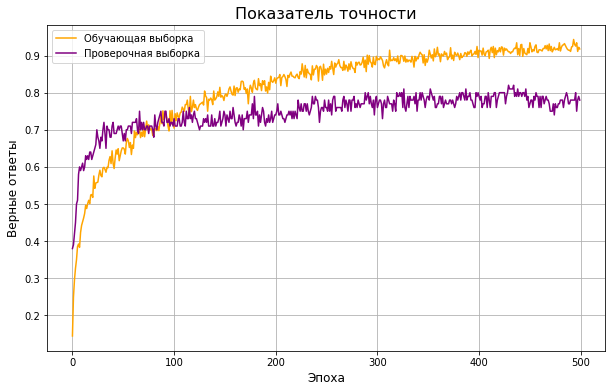

In [114]:
# # график показатель точности для каждой эпохи
plt.figure(figsize=(10, 6))
plt.plot(histoty_Dense.history['accuracy'], color='orange', label='Обучающая выборка')
plt.plot(histoty_Dense.history['val_accuracy'], color='purple', label='Проверочная выборка')
plt.title('Показатель точности', fontsize=16)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Верные ответы', fontsize=12)
plt.legend()
plt.grid()
plt.show()

Дообучаем Dense сеть

In [115]:
model_Dense.compile(optimizer=RMSprop(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [116]:
histoty_Dense = model_Dense.fit(X_train[:, indexes], y_train, epochs=250, batch_size=16, validation_data=(X_test[:, indexes], y_test))

Epoch 1/250
57/57 [==============================] - 2s 11ms/step - loss: 0.2287 - accuracy: 0.9144 - val_loss: 1.0637 - val_accuracy: 0.8000
Epoch 2/250
57/57 [==============================] - 0s 8ms/step - loss: 0.1899 - accuracy: 0.9300 - val_loss: 1.0630 - val_accuracy: 0.8000
Epoch 3/250
57/57 [==============================] - 0s 8ms/step - loss: 0.2465 - accuracy: 0.9267 - val_loss: 1.0641 - val_accuracy: 0.8000
Epoch 4/250
57/57 [==============================] - 0s 8ms/step - loss: 0.2318 - accuracy: 0.9156 - val_loss: 1.0684 - val_accuracy: 0.8000
Epoch 5/250
57/57 [==============================] - 0s 8ms/step - loss: 0.1847 - accuracy: 0.9322 - val_loss: 1.0677 - val_accuracy: 0.7900
Epoch 6/250
57/57 [==============================] - 0s 8ms/step - loss: 0.2350 - accuracy: 0.9267 - val_loss: 1.0616 - val_accuracy: 0.7900
Epoch 7/250
57/57 [==============================] - 0s 8ms/step - loss: 0.1907 - accuracy: 0.9467 - val_loss: 1.0609 - val_accuracy: 0.7800
Epoch 8/250


In [125]:
model_Dense.evaluate(X_test, y_test, verbose=1)

4/4 [==============================] - 0s 5ms/step - loss: 1.1339 - accuracy: 0.7900


[1.133887767791748, 0.7900000214576721]

In [126]:
# максимальная точность  и ошибка на обучающей и проверочной выборе
print(f'Максимальная Точность на обучающей выборке: {max(histoty_Dense.history["accuracy"])} \
\nМинимальная ошибка на обучающей выборе: {min(histoty_Dense.history["loss"])} \
\nМаксимальная Точность на проверочной выборке: {max(histoty_Dense.history["val_accuracy"])} \
\nМинимальная ошибка на проверочной выборе: {min(histoty_Dense.history["val_loss"])}')

Максимальная Точность на обучающей выборке: 0.9577777981758118 
Минимальная ошибка на обучающей выборе: 0.14478327333927155 
Максимальная Точность на проверочной выборке: 0.800000011920929 
Минимальная ошибка на проверочной выборе: 1.0569844245910645


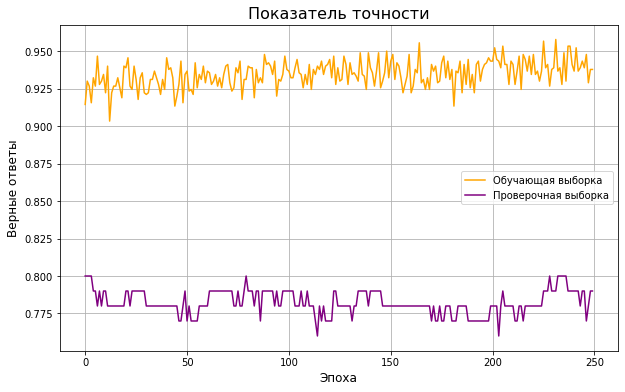

In [127]:
# # график показатель точности для каждой эпохи
plt.figure(figsize=(10, 6))
plt.plot(histoty_Dense.history['accuracy'], color='orange', label='Обучающая выборка')
plt.plot(histoty_Dense.history['val_accuracy'], color='purple', label='Проверочная выборка')
plt.title('Показатель точности', fontsize=16)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Верные ответы', fontsize=12)
plt.legend()
plt.grid()
plt.show()

VAR 2. Добавляем количество значений.

In [119]:
# Квадрат
X_train_sqr = np.array([[t**2 for t in x] for x in X_train])
X_test_sqr = np.array([[t**2 for t in x] for x in X_test])
# 3
X_train_3 = np.array([[t**3 for t in x] for x in X_train])
X_test_3 = np.array([[t**3 for t in x] for x in X_test])

# Квадратный корнь из абсолютных значений 
X_train_sqrt = np.array([[abs(t)**0.5 for t in x] for x in X_train])
X_test_sqrt = np.array([[abs(t)**0.5 for t in x] for x in X_test])

# 1/t
X_train_inv = np.array([[t**(-1) for t in x] for x in X_train])
X_test_inv = np.array([[t**(-1) for t in x] for x in X_test])

# 2 в степени t
X_train_exp = np.array([[2**t for t in x] for x in X_train])
X_test_exp = np.array([[2**t for t in x] for x in X_test])

# Объединяем все массивы(Функция hstack() соединяет массивы по горизонтали)
X_train_plus = np.hstack([X_train, X_train_sqr, X_train_sqrt, X_train_inv, X_train_exp, X_train_3])
X_test_plus = np.hstack([X_test, X_test_sqr, X_test_sqrt, X_test_inv, X_test_exp, X_test_3])

print(X_train_plus.shape)
print(X_test_plus.shape)

(900, 222)
(100, 222)


In [159]:
# Var. Plus
model_plus = Sequential([
                         BatchNormalization(input_shape=(X_train_plus.shape[1],)),                               #input_shape=(X_train_plus.shape[1],)))
                         #Dense(1024, activation='relu'),
                         #Dense(32, activation='relu'),
                         #Flatten(),
                         #BatchNormalization(),
                         #Dropout(0.5),
                         Dense(768, activation='relu'),
                         BatchNormalization(),
                         Dropout(0.5),
                         Dense(512, activation='relu'),
                         BatchNormalization(),
                         Dropout(0.3),
                         Dense(384, activation='relu'),
                         #BatchNormalization(),
                         Dropout(0.2),
                         #BatchNormalization(),
                         #Dense(128, activation='relu'),
                         #Dense(128, activation='relu'),
                         Dense(256, activation='relu'),
                         #BatchNormalization(),
                         Dropout(0.2),
                         #Dense(64, activation='relu'),
                         #Dense(64, activation='relu'),
                         #UpSampling2D(size=(2), data_format=None),
                         #Dropout(0.2),
                         #Dropout(0.4),
                         #BatchNormalization(),
                         #Dense(64, activation='relu'),
                         #BatchNormalization(),
                         Dense(128, activation='relu'),
                         #Dropout(0.2),
                         #Dense(16, activation='relu'),
                         #BatchNormalization(),
                         Flatten(),
                         Dense(10, activation='softmax')
                        ])


In [160]:
model_plus.compile(optimizer=RMSprop(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [161]:
model_plus.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_45 (Batc (None, 222)               888       
_________________________________________________________________
dense_114 (Dense)            (None, 768)               171264    
_________________________________________________________________
batch_normalization_46 (Batc (None, 768)               3072      
_________________________________________________________________
dropout_69 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_115 (Dense)            (None, 512)               393728    
_________________________________________________________________
batch_normalization_47 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_70 (Dropout)         (None, 512)             

In [162]:
history_plus = model_plus.fit(X_train_plus, y_train, epochs=250, batch_size=16, validation_data=(X_test_plus, y_test))

Epoch 1/250
57/57 [==============================] - 3s 18ms/step - loss: 2.3553 - accuracy: 0.1544 - val_loss: 2.1836 - val_accuracy: 0.4000
Epoch 2/250
57/57 [==============================] - 1s 14ms/step - loss: 2.1005 - accuracy: 0.2622 - val_loss: 1.9992 - val_accuracy: 0.4600
Epoch 3/250
57/57 [==============================] - 1s 15ms/step - loss: 1.9696 - accuracy: 0.2922 - val_loss: 1.7801 - val_accuracy: 0.4700
Epoch 4/250
57/57 [==============================] - 1s 15ms/step - loss: 1.8316 - accuracy: 0.3400 - val_loss: 1.6437 - val_accuracy: 0.5300
Epoch 5/250
57/57 [==============================] - 1s 15ms/step - loss: 1.6815 - accuracy: 0.4122 - val_loss: 1.5019 - val_accuracy: 0.5600
Epoch 6/250
57/57 [==============================] - 1s 15ms/step - loss: 1.6447 - accuracy: 0.4189 - val_loss: 1.4379 - val_accuracy: 0.5400
Epoch 7/250
57/57 [==============================] - 1s 15ms/step - loss: 1.5763 - accuracy: 0.4156 - val_loss: 1.3675 - val_accuracy: 0.5400
Epoch 

In [164]:
model_plus.evaluate(X_test_plus, y_test, verbose=1)

4/4 [==============================] - 0s 5ms/step - loss: 2.2819 - accuracy: 0.7800


[2.281858444213867, 0.7799999713897705]

In [165]:
# максимальная точность и минимальная ошибка на обучающей и проверочной выборе
print(f'Максимальная Точность на обучающей выборке: {max(history_plus.history["accuracy"])} \
\nМинимальная ошибка на обучающей выборе: {min(history_plus.history["loss"])} \
\nМаксимальная Точность на проверочной выборке: {max(history_plus.history["val_accuracy"])} \
\nМинимальная ошибка на проверочной выборе: {min(history_plus.history["val_loss"])}')

Максимальная Точность на обучающей выборке: 0.9733333587646484 
Минимальная ошибка на обучающей выборе: 0.084006167948246 
Максимальная Точность на проверочной выборке: 0.800000011920929 
Минимальная ошибка на проверочной выборе: 1.1570223569869995


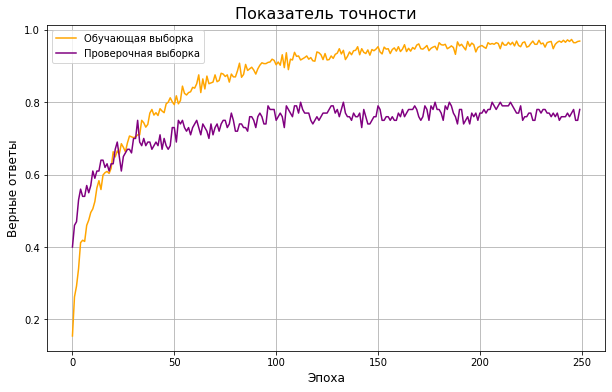

In [166]:
plt.figure(figsize=(10, 6))
plt.plot(history_plus.history['accuracy'], color='orange', label='Обучающая выборка')
plt.plot(history_plus.history['val_accuracy'], color='purple', label='Проверочная выборка')
plt.title('Показатель точности', fontsize=16)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Верные ответы', fontsize=12)
plt.legend()
plt.grid()
plt.show()

VAR3 Сеть с несколькими входами.

In [191]:
indexes = range(0, 37)

input = Input(len(indexes),)

x1 = BatchNormalization()(input)
x1 = Dense(768, activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.5)(x1)
x1 = Dense(512, activation='relu')(x1)
#x1 = Dense(256, activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.3)(x1)
#x1 = Dense(128, activation='relu')(x1)
#x1 = Dense(128, activation='relu')(x1)
#x1 = Dropout(0.2)(x1)
#x1 = Dense(64, activation='relu')(x1)
#x1 = Dense(64, activation='relu')(x1)
#x1 = Dropout(0.2)(x1)
#BatchNormalization(),
#x1 = Dense(32, activation='relu')(x1)
#x1 = Dense(32, activation='relu')(x1)


x2 = BatchNormalization()(input)
x2 = Dense(512, activation='relu')(x2)
#x2 = Dense(512, activation='relu')(x2)
#x2 = Flatten(x2),
x2 = BatchNormalization()(x2)
x2 = Dropout(0.4)(x2)
#x2 = BatchNormalization()(x2)
x2 = Dense(256, activation='relu')(x2)
#x2 = Dense(256, activation='relu')(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.3)(x2)
#x2 = Dense(128, activation='relu')(x2)
#x2 = Dense(128, activation='relu')(x2)
#x2 = Dropout(0.2)(x2)
#x2 = Dense(64, activation='relu')(x2)
#x2 = Dense(64, activation='relu')(x2)
#x2 = Dropout(0.2)(x2)
#x2 = BatchNormalization()(x2)
#x2 = Dense(32, activation='relu')(x2)
#x2 = Dense(32, activation='relu')(x2)


x3 = BatchNormalization()(input)
x3 = Dense(256, activation='relu')(x3)
#x3 = Dense(512, activation='relu')(x3)
#x3 = Flatten(x3),
x3 = BatchNormalization()(x3)
x3 = Dropout(0.3)(x3)
#x3 = BatchNormalization()(x3)
x3 = Dense(128, activation='relu')(x3)
#x3 = Dense(256, activation='relu')(x3)
x3 = BatchNormalization()(x3)
x3 = Dropout(0.2)(x3)
#x3 = Dense(128, activation='relu')(x3)
#x3 = Dense(128, activation='relu')(x3)
#x3 = Dropout(0.2)(x3)
#x3 = Dense(64, activation='relu')(x3)
#x3 = Dense(64, activation='relu')(x3)
#x3 = Dropout(0.2)(x3)
#x3 = BatchNormalization()(x3)
#x3 = Dense(32, activation='relu')(x3)
#x3 = Dense(32, activation='relu')(x3)


x = concatenate([x1, x2, x3])
#x = Flatten()(x)
#x = Dense(64, activation='relu')(x)
#x = BatchNormalization()(x)
x = Dense(32, activation='relu')(x)
x = Flatten()(x)
x = Dense(10, activation='softmax')(x)

In [192]:
model_var3 = Model(input, x)
model_var3.compile(optimizer=RMSprop(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [193]:
model_var3.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
batch_normalization_82 (BatchNo (None, 37)           148         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, 37)           148         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_88 (BatchNo (None, 37)           148         input_6[0][0]                    
____________________________________________________________________________________________

In [194]:
history_var3 = model_var3.fit(X_train[:,indexes], y_train, epochs=250, batch_size=16, validation_data=(X_test[:, indexes], y_test))

Epoch 1/250
57/57 [==============================] - 4s 18ms/step - loss: 2.4687 - accuracy: 0.2000 - val_loss: 2.0673 - val_accuracy: 0.3500
Epoch 2/250
57/57 [==============================] - 1s 13ms/step - loss: 2.0185 - accuracy: 0.3089 - val_loss: 1.9346 - val_accuracy: 0.3300
Epoch 3/250
57/57 [==============================] - 1s 14ms/step - loss: 1.7552 - accuracy: 0.4122 - val_loss: 1.7242 - val_accuracy: 0.3900
Epoch 4/250
57/57 [==============================] - 1s 14ms/step - loss: 1.6448 - accuracy: 0.4444 - val_loss: 1.5319 - val_accuracy: 0.4600
Epoch 5/250
57/57 [==============================] - 1s 13ms/step - loss: 1.5432 - accuracy: 0.4789 - val_loss: 1.3646 - val_accuracy: 0.5700
Epoch 6/250
57/57 [==============================] - 1s 14ms/step - loss: 1.4210 - accuracy: 0.5189 - val_loss: 1.2214 - val_accuracy: 0.5800
Epoch 7/250
57/57 [==============================] - 1s 13ms/step - loss: 1.3909 - accuracy: 0.5267 - val_loss: 1.1228 - val_accuracy: 0.6100
Epoch 

In [195]:
model_var3.evaluate(X_test, y_test, verbose=1)

4/4 [==============================] - 0s 5ms/step - loss: 1.0231 - accuracy: 0.7800


[1.0230907201766968, 0.7799999713897705]

In [196]:
# максимальная точность  и ошибка на обучающей и проверочной выборе
print(f'Максимальная Точность на обучающей выборке: {max(history_var3.history["accuracy"])} \
\nМинимальная ошибка на обучающей выборе: {min(history_var3.history["loss"])} \
\nМаксимальная Точность на проверочной выборке: {max(history_var3.history["val_accuracy"])} \
\nМинимальная ошибка на проверочной выборе: {min(history_var3.history["val_loss"])}')

Максимальная Точность на обучающей выборке: 0.9644444584846497 
Минимальная ошибка на обучающей выборе: 0.10659335553646088 
Максимальная Точность на проверочной выборке: 0.8100000023841858 
Минимальная ошибка на проверочной выборе: 0.804635763168335


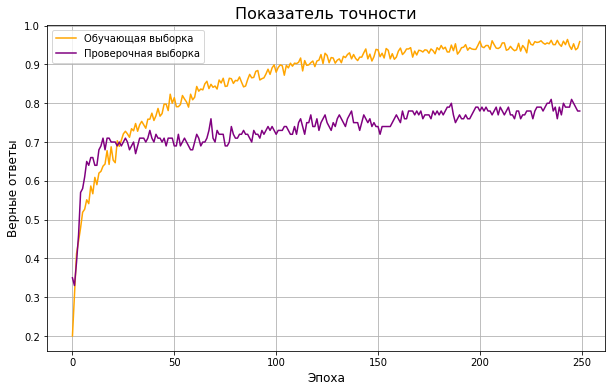

In [197]:
# # график показатель точности для каждой эпохи
plt.figure(figsize=(10, 6))
plt.plot(history_var3.history['accuracy'], color='orange', label='Обучающая выборка')
plt.plot(history_var3.history['val_accuracy'], color='purple', label='Проверочная выборка')
plt.title('Показатель точности', fontsize=16)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Верные ответы', fontsize=12)
plt.legend()
plt.grid()
plt.show()

Распознавание

In [198]:
song = '/content/drive/MyDrive/UAI/Data_CSV/genres_music/disco/disco.00007.au'

In [199]:
y, sr = librosa.load(song, mono=True, duration=90)
song_out = get_features(y, sr)

In [200]:
song_out = np.array(song_out).reshape(1, 37)

song_out.shape

(1, 37)

In [201]:
song_out = scaler.transform(song_out)

In [202]:
song_predict = model_Dense.predict(song_out)

In [203]:
print(song_predict)
print(np.argmax(song_predict))
print(music_genres.index('disco'))

[[2.5138720e-03 2.1170849e-01 1.0224052e-02 1.2774818e-06 3.0303320e-01
  1.0144104e-06 4.6471900e-01 7.7249301e-03 7.4019496e-05 5.7358342e-08]]
6
6
